# CIS053 Final Project - ML Titanic
Anne-Elise Chung
Hernanda Mak

## Executive Summary

todo -after everything else

## Background

The purpose of this project is to build a predictive model that can classify the sort of passenger on Titatic that will most likely survive after the shipwreck. Moreover, we aim to discover the most influential features that affect the possibility of survival among the Titanic passengers.

The sinking of the Titanic happened on April 15, 1912, where the resulting death of 1502 out of 2224 passengers led to global attention regarding safety of sea travelling and way to avoid another shipwreck of such sort. The major reason behind the disastrous outcome is the lack of lifeboats. Based on the collected data of survival history on the Titanic, we can understand and build a predictive model that would identify which type of poassenger could survive on such shipwreck.

## Survey of Existing Work

https://www.kaggle.com/code/abdmental01/exploring-data-visual-insights-unveiled#About-Function
- Author: MUHAMMAD ABDULLAH
- Techniques Used: this submission was purely showing some data visualization techniques, but it serves as a helpful comparison for the upcoming EDA work in this report.
- Results:
- ![results from data vis insights](exploring_data_vis_insights_revealed.png)

https://www.kaggle.com/code/gusthema/titanic-competition-w-tensorflow-decision-forests
- Author: GUSTHEMA
- Techniques Used: TensorFlow Decision Trees
- Results: 
- Notes: This Kaggle submission received 675 upvotes, compared to many of the other submissions that only received 2 or 3 upvotes. The popularity of this post might indicate that the results and techniques are probably sound and would be good for comparison.


https://www.kaggle.com/code/eneskosar19/titanic-sample-submission-random-forest
- Author:
- Techniques Used:
- Results:


https://www.kaggle.com/code/whitedevil4648/neural-networks-titanic
- Author: WHITEDEVIL4648
- Techniques Used: neural networks
- Results:
- Notes: 


## Our Approach


- EDA analysis
- Eliminate unuseful features and data entry
- Create classification models: ensemble trees (random forest, bagging , ADA boost), k-means clustering, decision tree classifier, SVM, logistic regression
- Standardize and Normalize to see if a more reliable model could be built
- Use cross validation to verify the accuracy of the models so to identify the best predictive model 

## Code and Results


In [2]:
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from numpy import set_printoptions
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [3]:
test_data = read_csv('./test.csv')
train_data = read_csv('./train.csv')

In [4]:
x = train_data.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = train_data['Survived']

X_arr = x.values
Y_arr = y.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [5]:
## descriptive stats
set_option('display.width', 100)
set_option('display.precision', 2)
description = x.describe()
print(description)

       Pclass     Age   SibSp   Parch    Fare
count  891.00  714.00  891.00  891.00  891.00
mean     2.31   29.70    0.52    0.38   32.20
std      0.84   14.53    1.10    0.81   49.69
min      1.00    0.42    0.00    0.00    0.00
25%      2.00   20.12    0.00    0.00    7.91
50%      3.00   28.00    0.00    0.00   14.45
75%      3.00   38.00    1.00    0.00   31.00
max      3.00   80.00    8.00    6.00  512.33


## Notes on Descriptive Statistics
-todo

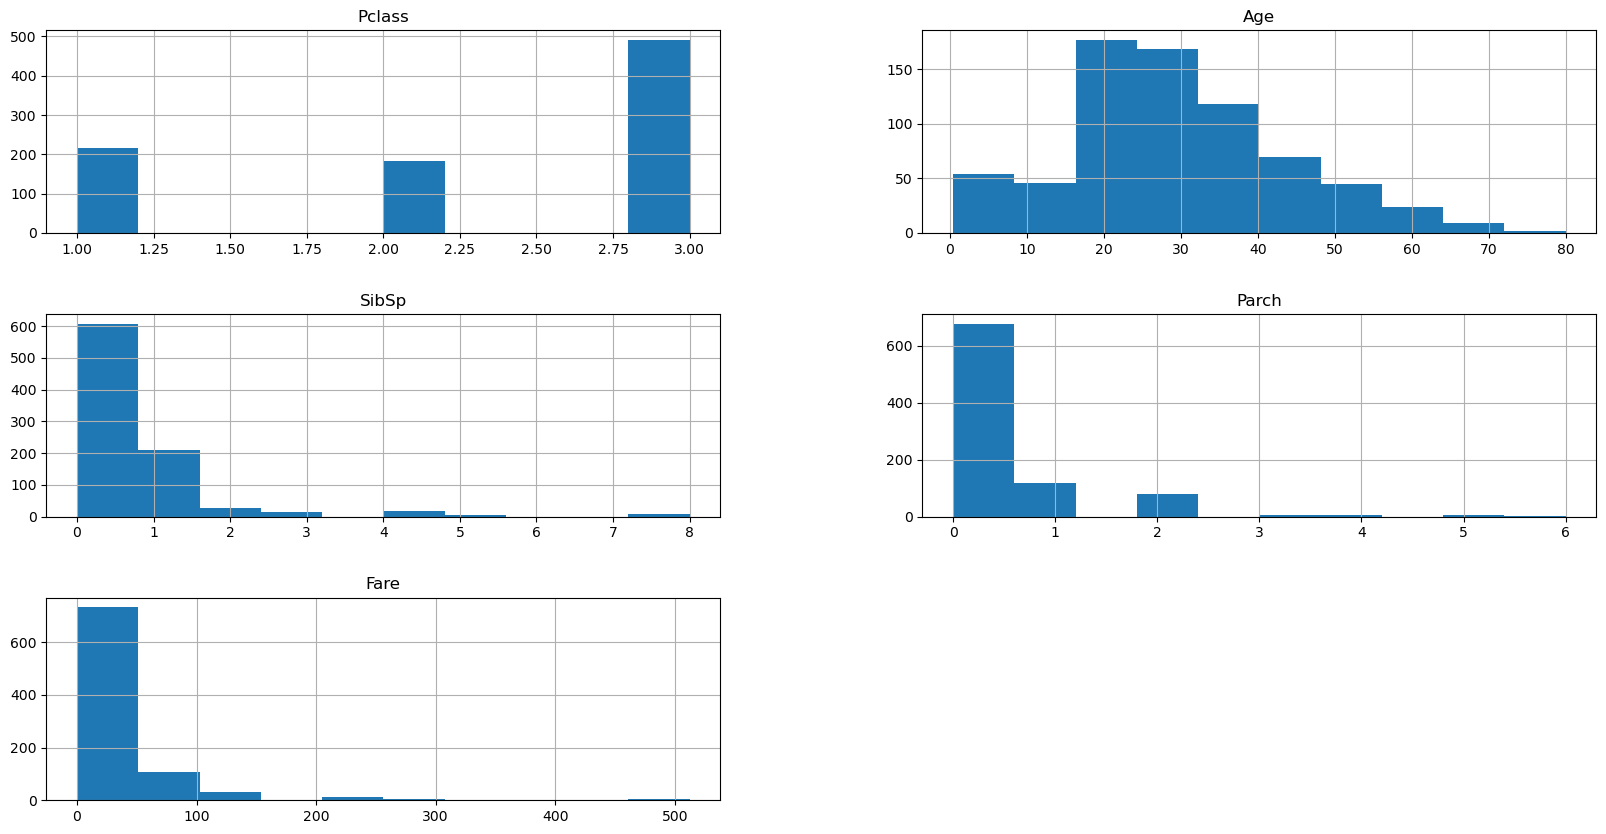

In [6]:
## histograms
x.hist(figsize = (20, 10))
plt.margins(2,2)
plt.subplots_adjust(hspace = 0.4)
plt.show()

# Notes on Histograms
-todo

C:\Users\a-e\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


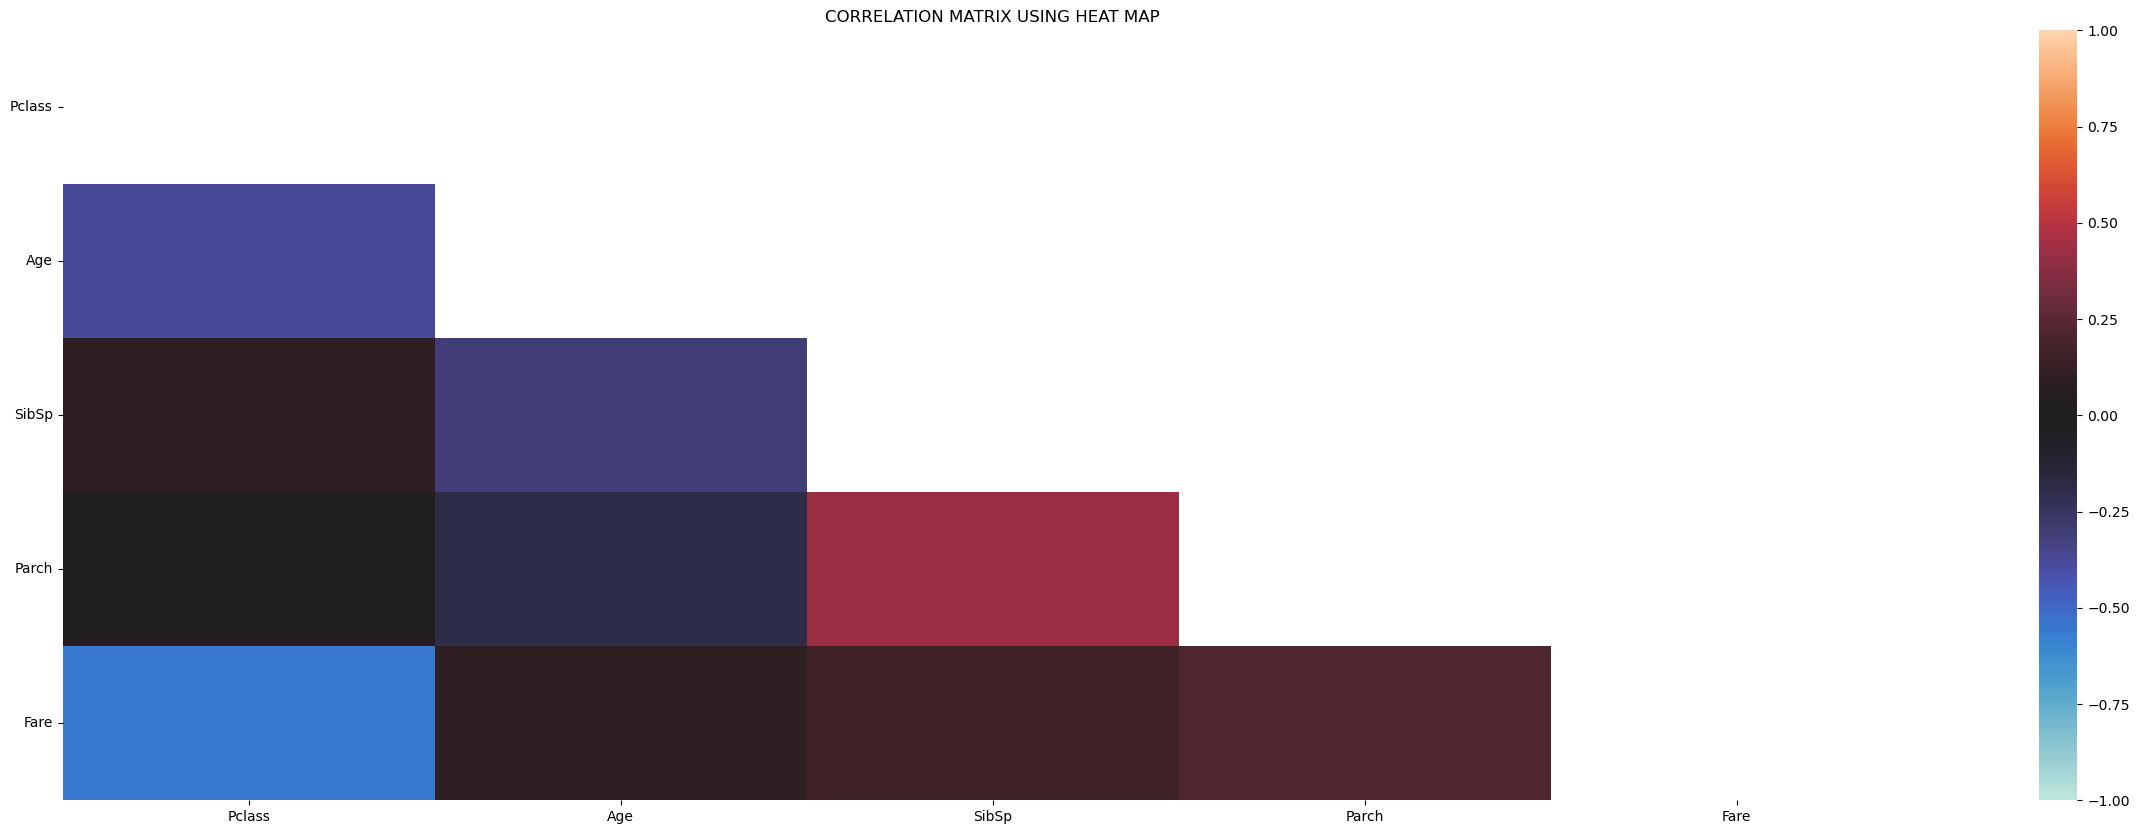

In [14]:
## correlation heatmap   
import seaborn as sns
import numpy as np

x_heatmap = x.drop(['Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
plt.figure(figsize=(30,10))
corMat = x_heatmap.corr(method="pearson")
mask_upper = np.triu(corMat)
sns.heatmap(corMat, annot=True, vmin = -1, vmax = 1, center = 0, mask = mask_upper)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("CORRELATION MATRIX USING HEAT MAP")
plt.show()

## Notes on Heatmap
-todo

## Conclusions
todo -after everything else

## References


## Appendix

https://github.com/aelichung/ml-titanic